# Group convolutions in PLiNIO

## Requirements

Install requirements for this and other examples as follows:
```bash
pip install -r <plinio_folder>/examples/requirements.txt
```

## Content

Group convolutions are convolutional layers were groups arguments is set as different than 1 and different than the number of channels (this last case is a depthwise).

Such convolutional layers are currently not supported as is, so they must be replaced by a completely equivalent component that slice the input, apply different convolutions in parallel to each slice and then concatenate the outputs.

In this way it is possible to apply all three algorithms to a model using grouped convolutions

### Example
Here the example of a net using a convolutions with groups=2 in the second layer:

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from plinio.methods import PIT

In [2]:
class UnsupportedGroupedConv_1D(nn.Module):
    def __init__(self):
        super(UnsupportedGroupedConv_1D, self).__init__()
        self.input_shape = (16, 2)
        self.conv0 = nn.Conv1d(16, 16, 5, padding="same", groups=1)
        self.conv1 = nn.Conv1d(16, 8, 3, padding="same", groups=2)
        self.conv3 = nn.Conv1d(8, 16, 3, padding="same", groups=1)

    def forward(self, x):
        x0  = F.relu(self.conv0(x))
        x1 = F.relu(self.conv1(x0))
        x4 = F.relu(self.conv3(x1))
        return x4

The second layer must be replaced by a convolution for each group, like in this scheme:
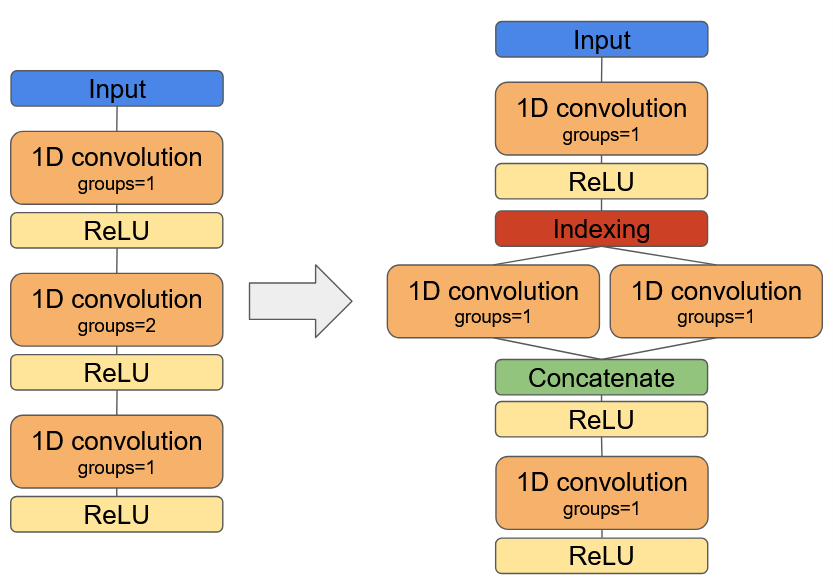
In code:
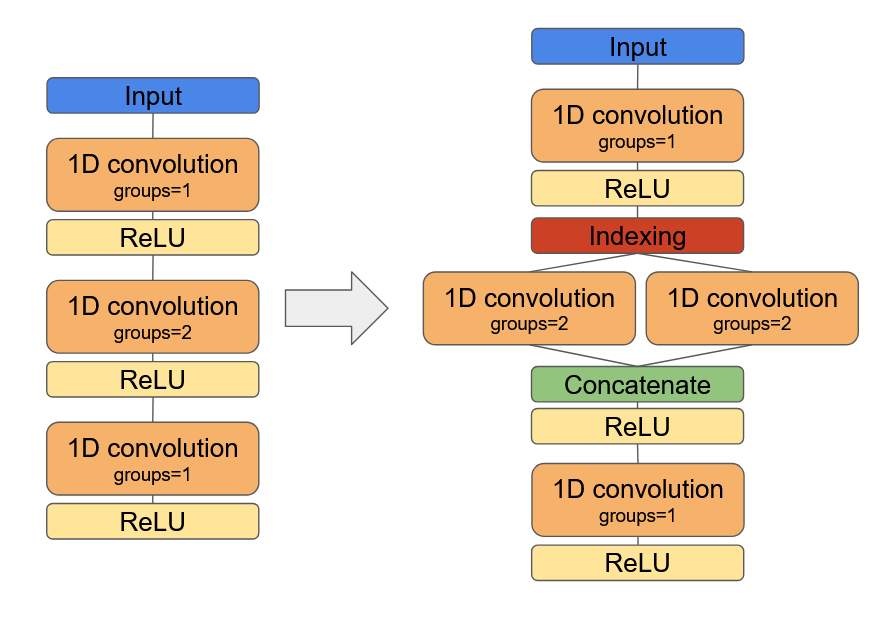

In [3]:
class ExampleGroupedConv_1D(nn.Module):
    def __init__(self, groups=2):
        super(ExampleGroupedConv_1D, self).__init__()
        self.input_shape = (16, 2)
        #2 parallel conv replace a conv(groups=2)
        self.conv0 = nn.Conv1d(16, 16, 5, padding="same", groups=1)
        self.conv1 = nn.Conv1d(8, 4, 3, padding="same", groups=1)
        self.conv2 = nn.Conv1d(8, 4, 3, padding="same", groups=1)
        self.conv3 = nn.Conv1d(8, 16, 3, padding="same", groups=1)

    def forward(self, x):
        x0  = F.relu(self.conv0(x))
        x1 = x0[:,0:8]
        x2 = x0[:,8:16]
        x1 = F.relu(self.conv1(x1))
        x2 = F.relu(self.conv2(x2))
        x3 = torch.cat((x1, x2), dim=1)
        x4 = self.conv3(x3)
        return x4

This model can now be converted using Supernet, PIT and MPS constructors:

In [ ]:
from torchinfo import summary
"""Test the conversion of a simple model with grouped convolutions"""
nn_ut = ExampleGroupedConv_1D()
new_nn = PIT(nn_ut, input_shape=nn_ut.input_shape)

print("Original model:")
print(summary(nn_ut, (1,) + nn_ut.input_shape, depth=8))
print("\nConverted model:\n")
print(summary(new_nn, (1,) + nn_ut.input_shape, depth=12))

Original model:
Layer (type:depth-idx)                   Output Shape              Param #
ExampleGroupedConv_1D                    [1, 16, 2]                --
├─Conv1d: 1-1                            [1, 16, 2]                1,296
├─Conv1d: 1-2                            [1, 4, 2]                 100
├─Conv1d: 1-3                            [1, 4, 2]                 100
├─Conv1d: 1-4                            [1, 16, 2]                400
Total params: 1,896
Trainable params: 1,896
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01

Converted model:

Layer (type:depth-idx)                   Output Shape              Param #
PIT                                      [1, 16, 2]                --
├─ExampleGroupedConv_1D: 1-1             --                        --
│    └─PITConv1d: 2-1                    [1, 16, 2]                1,320
│    └─PITConv1d: 2-2                

Multiple groups can be optimized using the same configuration:

In [14]:
class ExampleMultiGroupConv_1D(nn.Module):
    def __init__(self, in_channels, out_channels, groups=3):
        super(ExampleMultiGroupConv_1D, self).__init__()
        #2 parallel conv replace a conv(groups=2)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.input_shape = (self.in_channels, 2)
        self.groups=groups

        self.conv0 = nn.Conv1d(self.in_channels, self.in_channels, 5, padding="same", groups=1)
        self.groupconvs = nn.Sequential()
        for _ in range(self.groups):
            self.groupconvs.append(nn.Conv1d(self.in_channels//groups, self.out_channels//groups, 3, padding="same", groups=1))
        self.conv_final = nn.Conv1d(self.out_channels, self.in_channels, 3, padding="same", groups=1)

    def forward(self, x):
        x0  = F.relu(self.conv0(x))
        x2=[]
        for i in range(self.groups):
            x1 = x0[:,i*self.in_channels//self.groups:(i+1)*self.in_channels//self.groups,:]
            x2.append(self.groupconvs[i](x1))
        x3 = torch.cat(x2, dim=1)
        x4 = self.conv_final(x3)
        x4 = F.relu(x4)
        return x4

And it works the same with 2d convolutions too:

In [15]:
class ExampleGroupedConv_2D(nn.Module):
    def __init__(self, groups=2):
        super(ExampleGroupedConv_2D, self).__init__()
        self.input_shape = (16, 8, 8)
        #2 parallel conv replace a conv(groups=2)
        self.conv0 = nn.Conv2d(16, 16, 5, padding="same", groups=1)
        self.conv1 = nn.Conv2d(8, 4, 3, padding="same", groups=1)
        self.conv2 = nn.Conv2d(8, 4, 3, padding="same", groups=1)
        self.conv3 = nn.Conv2d(8, 16, 3, padding="same", groups=1)

    def forward(self, x):
        x0  = F.relu(self.conv0(x))
        x1 = x0[:,0:8]
        x2 = x0[:,8:16]
        x1 = F.relu(self.conv1(x1))
        x2 = F.relu(self.conv2(x2))
        x3 = torch.cat((x1, x2), dim=1)
        x4 = self.conv3(x3)
        return x4